In [101]:
import numpy as np
import camb
from camb import model
import matplotlib.pyplot as plt
import healpy as hp
from tqdm import tqdm

In [102]:
params = camb.CAMBparams()
params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.12, mnu=0.06, omk=0)
params.InitPower.set_params(ns=0.965)
results = camb.get_results(params)
powers = results.get_cmb_power_spectra(params, CMB_unit="muK")


tt_spectrum = powers['total'].T[0]
ell_values = np.arange(len(tt_spectrum))

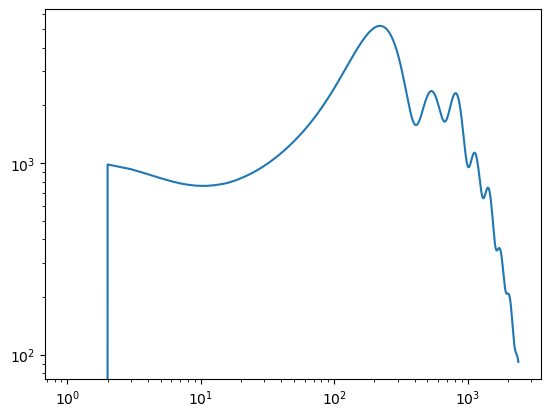

In [103]:
plt.loglog(ell_values,tt_spectrum)

In [104]:
nside = 16
temperature_map = hp.synfast(tt_spectrum, nside, new=True)

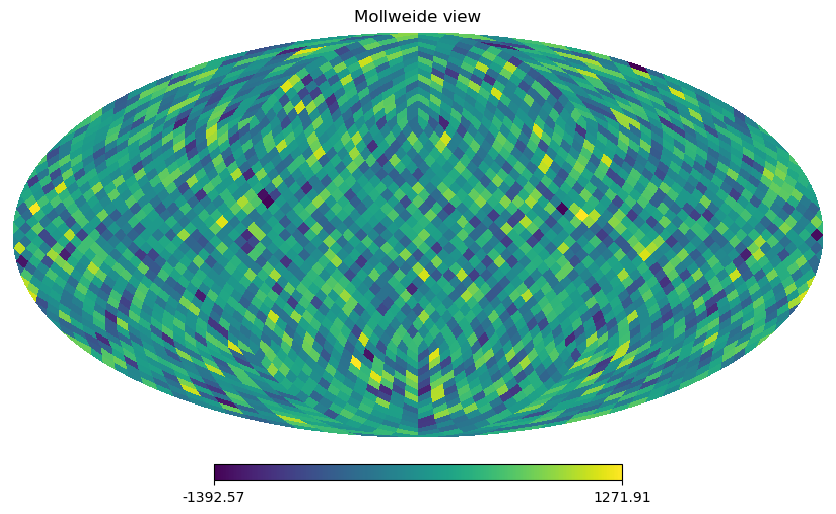

In [105]:
hp.mollview(temperature_map)

In [106]:
npix = hp.nside2npix(nside)


random_pixel_index = np.random.randint(0, npix)


theta, phi = hp.pix2ang(nside, random_pixel_index)
ra_deg = np.degrees(phi)
dec_deg = np.degrees(0.5 * np.pi - theta)


patch_radius_deg = 40.0
patch_pixel_indices = hp.query_disc(nside, hp.ang2vec(theta, phi), np.radians(patch_radius_deg))

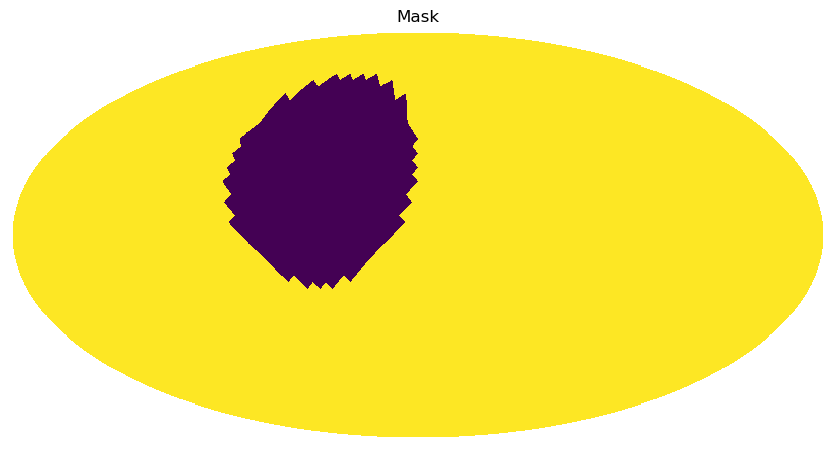

In [107]:
mask = np.ones(npix)
mask[patch_pixel_indices] = 0
hp.mollview(mask, title='Mask', cbar=False)

In [108]:
num_shuffles = 100
power_spectra_array = []

for _ in tqdm(range(num_shuffles), desc="Shuffling the patch pixels", unit="iteration"):
    
    shuffled_map = temperature_map.copy()
    patch_values = shuffled_map[patch_pixel_indices]
    np.random.shuffle(patch_values)
    shuffled_map[patch_pixel_indices] = patch_values

    
    power_spectrum = hp.anafast(shuffled_map)

    
    power_spectra_array.append(power_spectrum)


mean_power_spectrum = np.mean(power_spectra_array, axis=0)


Shuffling the patch pixels: 100%|██████████| 100/100 [00:00<00:00, 717.92iteration/s]


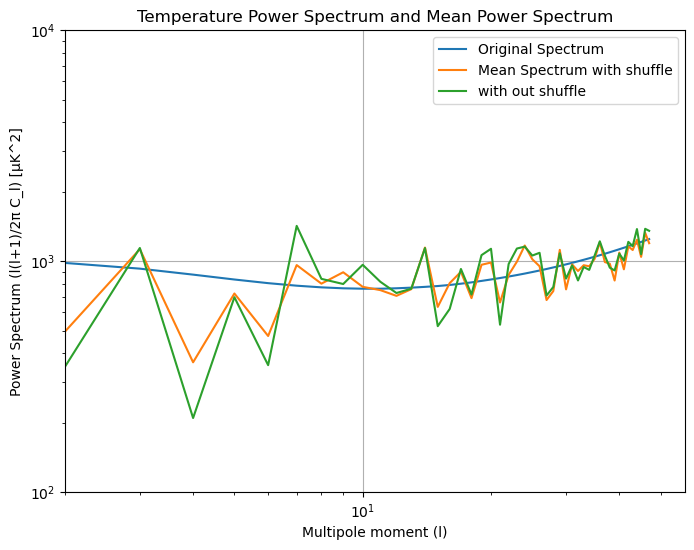

In [109]:

# Plot the original and mean power spectra
ltt = len(mean_power_spectrum)
plt.figure(figsize=(8, 6))
plt.plot(ell_values[:ltt], tt_spectrum[:ltt], label="Original Spectrum")
plt.plot(ell_values[:ltt], mean_power_spectrum, label="Mean Spectrum with shuffle")
plt.loglog(ell_values[:ltt], hp.anafast(temperature_map),label='with out shuffle')
plt.xlabel('Multipole moment (l)')
plt.ylabel('Power Spectrum (l(l+1)/2π C_l) [μK^2]')
plt.title('Temperature Power Spectrum and Mean Power Spectrum')
plt.legend()
plt.xlim(2,None)
plt.ylim(1e2,1e4)
plt.grid()
plt.show()

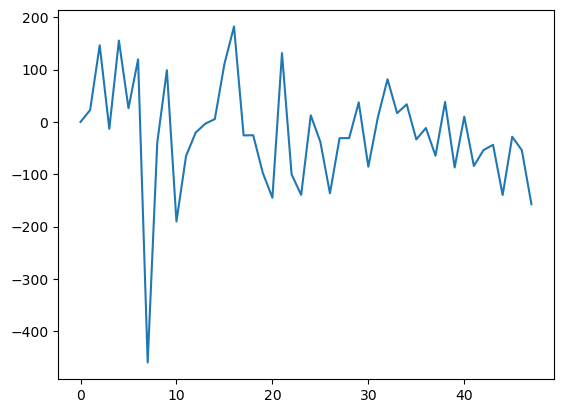

In [110]:
plt.plot(mean_power_spectrum-hp.anafast(temperature_map))